In [1]:
# download dataset from github

! git clone https://github.com/zabir-nabil/pytorch-nlp.git

Cloning into 'pytorch-nlp'...
remote: Enumerating objects: 2143, done.
remote: Counting objects: 100% (2143/2143), done.
remote: Compressing objects: 100% (2140/2140), done.
remote: Total 2143 (delta 2), reused 2139 (delta 2), pack-reused 0
Receiving objects: 100% (2143/2143), 4.79 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
# installing

! pip install torch
! pip install transformers

     |████████████████████████████████| 675kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 11.8MB/s 
     |████████████████████████████████| 890kB 25.5MB/s 
     |████████████████████████████████| 3.8MB 28.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c590b0f1e4a063c023eea02190fd468b8f3f0d31aa5ffe167b14cd2e97ec8700
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
data_path = 'pytorch-nlp/bbc'

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

# inside these folders there are multiple text files

import glob
import os

texts = [] # texts from all the text files
class_labels = [] # labels

for c in classes:
    for f in glob.glob(os.path.join(data_path, c, '*.txt')):
        # print(f)
        texts.append(open(f, 'r', encoding='unicode_escape').read())
        class_labels.append(c)

In [9]:
print(len(texts))
print(len(class_labels))
print(texts[0])
print(class_labels[0])

2225
2225
Wall Street cool to eBay's profit

Shares in online auction house eBay fell 9.8% in after-hours trade on Wednesday, after its quarterly profits failed to meet market expectations.

Despite seeing net profits rise by 44% to $205.4m (Â£110m) during October to December, from $142m a year earlier, Wall Street had expected more. EBay stock fell to $92.9 in after-hours trade, from a $103.05 end on Nasdaq. EBay's net revenue for the quarter rose to $935.8m from $648.4m, boosted by growth at its PayPal payment service.

Excluding special items, eBay's profit was 33 cents a share, but analysts had expected 34 cents.

"I think Wall Street has gotten a bit ahead of eBay this quarter and for the 2005 year." said Janco Partners analyst Martin Pyykkonen. For 2004 as a whole, eBay earned $778.2m on sales of $3.27bn. EBay president and chief executive Meg Whitman called 2004 an "outstanding success" that generated "tremendous momentum" for 2005. "I'm more confident than ever that the decisio

In [0]:
# Random Seed and Data Shuffling

import random
import numpy
import torch

random.seed(10)
numpy.random.seed(10)
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

z = list(zip(texts, class_labels))
random.shuffle(z)

texts, class_labels = [a[0] for a in z], [a[1] for a in z]

In [11]:
class_labels[-20:]

['sport',
 'entertainment',
 'sport',
 'business',
 'sport',
 'politics',
 'business',
 'sport',
 'tech',
 'tech',
 'business',
 'entertainment',
 'politics',
 'tech',
 'tech',
 'entertainment',
 'business',
 'tech',
 'sport',
 'business']

In [12]:
# class distribution
from collections import Counter
Counter(class_labels)

Counter({'business': 510,
         'entertainment': 386,
         'politics': 417,
         'sport': 511,
         'tech': 401})

In [14]:
# Tokenizers

import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', max_length = 512, padding_side = 'right')

In [0]:
from transformers import BertForSequenceClassification

num_class = 5 # we have 5 classes

bertclassifier = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 5)

In [0]:
from torch.utils.data import Dataset, DataLoader

# create our dataset

class BBCArticleDataset(Dataset):
    def __init__(self, texts, class_labels, class_id, tokenizer, train = True, train_split = 0.8): # pass the text and the labels, class_id : dict -> ohe
        
        self.train = train
        
        assert(len(class_labels) == len(texts))
        assert(type(class_id) == dict)
        
        if self.train:
            self.texts = texts[: int(len(texts)*train_split) ]
            self.class_labels = class_labels[: int(len(texts)*train_split) ]
        else:
            self.texts = texts[ int(len(texts)*train_split): ]
            self.class_labels = class_labels[ int(len(texts)*train_split): ]
        self.class_id = class_id
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.class_labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        encoded = tokenizer.encode_plus(self.texts[idx], add_special_tokens=True, max_length = 512, pad_to_max_length = True,
                                return_token_type_ids = False,
                                return_attention_mask = True)  # Batch size 1
            
        # text to tokens
        token = torch.tensor(encoded['input_ids']) #.unsqueeze(0)
        mask = torch.tensor(encoded['attention_mask'])
        # ohe label
        ohe = torch.tensor(class_id[ class_labels[idx] ])
        
        if self.train:
            return token, mask, ohe
        else:
            return token, mask, ohe # with masks

In [0]:
class_id = {'business' : 0, 'entertainment' : 1,
           'politics' : 2, 'sport' : 3,
           'tech' : 4}

bbc_dataset_train = BBCArticleDataset(texts, class_labels, class_id, tokenizer)
bbc_dataset_test = BBCArticleDataset(texts, class_labels, class_id, tokenizer, train = False)

# in colab, we can use high batch size

bbc_dataloader_train = DataLoader(bbc_dataset_train, batch_size=8, shuffle=True) 
bbc_dataloader_test = DataLoader(bbc_dataset_test, batch_size=8, shuffle=True)

In [20]:
import transformers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda for gpu acceleration

# optimizer

optimizer = transformers.AdamW(bertclassifier.parameters(), lr = 1e-5)


bertclassifier.to(device) # taking the model to gpu if possible

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# training epochs

epochs = 5

# metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_losses = []

train_metrics = {'acc': [], 'f1': []}
test_metrics = {'acc': [], 'f1': []}

# progress bar

from tqdm import tqdm_notebook

for e in tqdm_notebook(range(epochs)):
    train_loss = 0.0
    train_acc = 0.0
    train_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.train()
    
    print(f'epoch: {e+1}')
    
    for i_batch, (X, X_mask, y) in tqdm_notebook(enumerate(bbc_dataloader_train)):
        X = X.to(device)
        X_mask = X_mask.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        loss, y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)

        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(bertclassifier.parameters(), 1.0)

        optimizer.step()
        
        y_pred = torch.argmax(y_pred, dim = -1)
        
        # update metrics
        train_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        train_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'micro')
        batch_cnt += 1
    
    print(f'train loss: {train_loss/batch_cnt}')
    print(f'acc: {train_acc/batch_cnt}')
    print(f'f1: {train_f1/batch_cnt}')
    train_losses.append(train_loss/batch_cnt)
    train_metrics['acc'].append(train_acc/batch_cnt)
    train_metrics['f1'].append(train_f1/batch_cnt)
        
        
    test_loss = 0.0
    test_acc = 0.0
    test_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.eval()
    with torch.no_grad():
        for i_batch, (X, X_mask, y) in enumerate(bbc_dataloader_train):
            X = X.to(device)
            X_mask = X_mask.to(device)
            y = y.to(device)

            y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)[1] # in eval model we get the softmax output so, don't need to index

            
            y_pred = torch.argmax(y_pred, dim = -1)

            # update metrics
            test_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            test_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'micro')
            batch_cnt += 1
            
    test_metrics['acc'].append(test_acc/batch_cnt)
    test_metrics['f1'].append(test_f1/batch_cnt)
    print(f'test acc: {test_acc/batch_cnt}')
    print(f'test f1: {test_f1/batch_cnt}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train loss: 0.6800620861251258
acc: 0.7752242152466368
f1: 0.7752242152466368
test acc: 0.9837443946188341
test f1: 0.9837443946188341
epoch: 2



train loss: 0.07217398773661643
acc: 0.984304932735426
f1: 0.984304932735426
test acc: 0.9943946188340808
test f1: 0.9943946188340808
epoch: 3



train loss: 0.03656181786626978
acc: 0.992152466367713
f1: 0.992152466367713
test acc: 0.9983183856502242
test f1: 0.9983183856502242
epoch: 4



train loss: 0.017982882368190407
acc: 0.9949551569506726
f1: 0.9949551569506726
test acc: 0.9988789237668162
test f1: 0.9988789237668162
epoch: 5



train loss: 0.016345082644389882
acc: 0.9971973094170403
f1: 0.9971973094170403
test acc: 0.9977578475336323
test f1: 0.9977578475336323



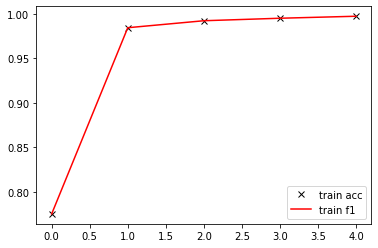

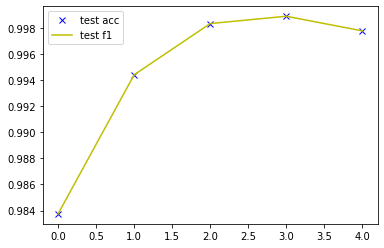

In [27]:
# plotting the result

import matplotlib.pyplot as plt

plt.plot(train_metrics['acc'], 'kx')
plt.plot(train_metrics['f1'], 'r')
plt.legend(['train acc', 'train f1'])
plt.show()
plt.plot(test_metrics['acc'], 'bx')
plt.plot(test_metrics['f1'], 'y')
plt.legend(['test acc', 'test f1'])
plt.show()